# Create fake images of gaussian psfs and compare evidence.




In [1]:
import numpy as np

from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy import constants as const
from astropy import wcs
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.table import Table, Column, join, hstack

import json


import scipy.stats, scipy

import matplotlib.pyplot as plt




import pymultinest
from pymultinest.solve import solve


import math, os

import scipy
import scipy.interpolate
import scipy.ndimage

import time

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('figure', figsize=(10, 6))


## Simple image tests

We were given some example code from Jason Glenn. To begin we test that we can open the images and use them as anticipated. The code had to be changed from Python 2 to 3.

In [2]:
#data_folder = "/Volumes/Raph500/GEP"
DAT_FOL = './' #"/Users/rs548/GitHub/GEP"
OUT_FOL='./data/fakes/'

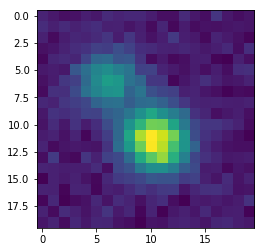

In [3]:
def make_fake_image(n_gaussians, 
                    psf_size   = 2.,         #pixels 
                    image_size = 10,         #pixels 
                    buffer     = 5,          #pixels
                    background = 0.,         #uJy
                    flux_range = [10., 100.], #uJy
                    depth      = 0.,        #uJy
                    save       = False
                   ):
    """
    Make a fake image with a given number of Gaussians
    
    Randomly choose n fluxes and put n Gaussians with those fluxes at 
    random positions.
    
    This will be used to test algorithms for calculating the 
    number of objects.
    
    Inputs
    ------
    n_gaussians: int
        Number of gaussian objects to add to image
    psf_size: float
        Point Spread Function (PSF) standard deviation in pixel scale.
    image_size: int
        The number of pixels in the central square region.
    buffer: int
        The number of pixels to border the central region.
    background: float
        Background to add to every pixel.
    flux_range: list of two floats
        Lower and upper flux to uniformly sample from in uJy.
    depth: float
        Standard deviation of Gaussian noise to add to image.
        
    
    Returns
    -------
    image: np.array
        2D array with n gaussians randomly placed around central pixel space
    """
    
    psf = Gaussian2DKernel(psf_size,x_size=101,y_size=101)
    
    image = np.full([image_size + 2*buffer,image_size + 2*buffer], 0.)
    
    for gal in np.arange(n_gaussians):
        gal_x = np.random.choice(np.arange(image_size))
        gal_y = np.random.choice(np.arange(image_size))
        gal_flux = np.random.uniform(flux_range[0],flux_range[1])
        image[gal_y + buffer, gal_x + buffer] = gal_flux
        #print("Object {}: x = {}, y = {}, flux = {}".format(gal, gal_x, gal_y, gal_flux))
    
    image = convolve(image, psf)
    
    # Add background
    image = image + background
    
    # Add noise
    noise = depth * np.random.randn(image.shape[0], image.shape[1])
    image = image + noise
    
    # Save image with key info
    if save:
        np.save(OUT_FOL + 'fake_x{}_y{}_f{}_t{}.npy'.format(gal_x, gal_y, gal_flux, time.time()), image)
    
    
    
    return image
    
    
    
test_image = make_fake_image(3, save=True, depth=0.1)
plt.imshow(test_image)

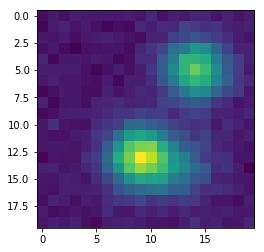

In [4]:
def make_model_image(n_gaussians, 
                     positions,        
                     fluxes,                  #uJy
                     psf_size   = 2.,         #pixels 
                     image_size = 10,         #pixels 
                     buffer     = 5,          #pixels
                     noise      = None,
                     background = 0.,  #uJy
                     save       = False
                    ):
    """
    Make a model image with a given number of Gaussians
    
    Randomly choose n fluxes and put n Gaussians with those fluxes at 
    random positions.
    
    This will be used to test algorithms for calculating the 
    number of objects.
    
    Inputs
    ------
    n_gaussians: int
        Number of gaussian objects to add to image
    psf_size: float
        Point Spread Function (PSF) standard deviation in pixel scale.
    image_size: int
        The number of pixels in the central square region.
    buffer: int
        The number of pixels to border the central region.
    background: float
        Background to add to every pixel.
        
    
    Returns
    -------
    image: np.array
        2D array with model image
    """
    #print("make model called")
    psf = Gaussian2DKernel(psf_size,x_size=101,y_size=101)
    
    model_image = np.full([image_size + 2*buffer,image_size + 2*buffer], 0.)
    
    #print("before loop")
    for n, gal in enumerate(positions):
        gal_x = gal[0]
        gal_y = gal[1]
        #print('gal_x: {}, gal_y: {}'.format(gal_x,gal_y))
        gal_flux = fluxes[n]
        #print(gal_flux)
        model_image[gal_y + buffer, gal_x + buffer] = gal_flux
        #print("loop {} done".format(n))
    
    model_image = convolve(model_image, psf)
    
    # Add background
    model_image = model_image + background
    
    # Add noise
    if noise != None:
        noise = noise * np.random.randn(model_image.shape[0], model_image.shape[1])
        model_image = model_image + noise
    
    # Save image with key info
    if save:
        np.save(OUT_FOL + 'fake_x{}_y{}_f{}_t{}.npy'.format(gal_x, gal_y, gal_flux, time.time()), image)
    
    
    #print("Make model finished")
    return model_image
    

    
test_model = make_model_image(3, [[9,0], [8,9], [4,8]], [75., 29., 89.], noise = 0.1)
plt.imshow(test_model)

## PyMultiNest Example

The example evidence calculations are for the egg box problem presented in Feroz et al (2008).

In [6]:
# probability function, taken from the eggbox problem.

def myprior(cube):
        return cube * 10 * np.pi

def myloglike(cube):
        chi = (np.cos(cube / 2.)).prod()
        return (2. + chi)**5

# number of dimensions our problem has
parameters = ["x", "y"]
#parameters = ["x", "y", "z", "j"]
n_params = len(parameters)


# name of the output files
#prefix = "chains/3-"
prefix = "chains/{}-".format(n_params + 1)

# run MultiNest
result = solve(LogLikelihood=myloglike, Prior=myprior,
        n_dims=n_params, outputfiles_basename=prefix, verbose=True)

print()
print('evidence: %(logZ).1f +- %(logZerr).1f' % result)
print()
print('parameter values:')
for name, col in zip(parameters, result['samples'].transpose()):
        print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))

# make marginal plots by running:
# $ python multinest_marginals.py chains/3-
# For that, we need to store the parameter names:

with open('{}params.json'.format(prefix), 'w') as f:
    json.dump(parameters, f, indent=2)

  analysing data from chains/3-.txt

evidence: 236.0 +- 0.1

parameter values:
              x : 14.335 +- 8.119
              y : 15.483 +- 9.094


## Define prior and liklihood

We want to define a prior for the parameters of n gaussians and a background.

The model is background plus n Gaussians plus noise. Lets ignore the background for now and assume we know it is 0. We then have n Gaussians each with a uniformly distributed position and flux


In [9]:
def general_prior(n_gaussians, x_l, x_u, y_l, y_u, f_l, f_u):
    """
    Return position in D-dimensional parameter space according to 
    location in D-dimensional unit hypercube.
    
    I.e. if one randomly samples from the uniformly distributed unit 
    hypercube and passes that sample to this function the result will
    be randomly sampled from the parameter prior.
    
    The prior is defined by a transformation of the D-dimensional hypercube
    
    Inputs
    ------
    cube: array of floats
        position in unit hypercube of random sample
        
    Returns
    -------
    prior: function object
        The prior function that turns positions in the unit hypercube to 
        positions in parameter space.
    """
    #print("general_prior called")
    def prior(cube):
        """Return position in parameter space given position in unit hypercube
        """
        #print("prior called")

        out_cube = cube #.copy()
        for n in np.arange(n_gaussians):
            out_cube[0 + 3*n] = x_l + out_cube[0 + 3*n] * (x_u - x_l) # x pixel
            out_cube[1 + 3*n] = y_l + out_cube[1 + 3*n] * (y_u - y_l) # y pixel
            out_cube[2 + 3*n] = f_l + out_cube[2 + 3*n] * (f_u - f_l) # flux
        return out_cube
        
    return prior

n_gaussians = 3
x_l = 0
x_u = 10
y_l = 0
y_u = 10
f_l = 10.
f_u = 100.
truth = [0, 9, 75., 8, 9, 29., 4, 8, 89.]
truth_cube_close = np.array([0.,0.9,0.7222, 0.8, 0.9, 0.211, 0.4, 0.8, 0.878])
general_prior(n_gaussians, x_l, x_u, y_l, y_u, f_l, f_u)(truth_cube_close)

array([  0.   ,   9.   ,  74.998,   8.   ,   9.   ,  28.99 ,   4.   ,
         8.   ,  89.02 ])

In [10]:
def chi_squared(image, model, error):
    """Return chi-squared for a given image and model
    
    Inputs
    ------
    image: np.array
        The image to fit
    model: np.array
        The model image
    """
    #Ignore constant term
    chi_squared = -0.5 * np.sum((image - model)**2/ error**2 )
    return chi_squared

In [11]:
def general_loglike(n_gaussians, x_l, x_u, y_l, y_u, f_l, f_u, image, error=0.1):
    """Return Log10 liklihood for model made from unit hypercube parameter space
    """
    #print("general_loglike called")
        
    def loglike(cube):
        
        #print("loglike called")

    
        # First get parameter values
        #print('like prior calling {}'.format(n_gaussians))
        #prior = general_prior(n_gaussians, x_l, x_u, y_l, y_u, f_l, f_u)
        #parameters = prior(cube)
        parameters = cube.copy()
        #print(len(parameters))
        #for n in np.arange(int(len(parameters)/3)):
        #    print(n)
        #    parameters[0 + 3*n] = x_l + parameters[0 + 3*n] * (x_u - x_l) # x pixel
        #    parameters[1 + 3*n] = y_l + parameters[1 + 3*n] * (y_u - y_l) # y pixel
        #    parameters[2 + 3*n] = f_l + parameters[2 + 3*n] * (f_u - f_l) # flux
        
        positions = []
        fluxes = []
        
        for gal in np.arange(int(len(parameters)/3)):
            positions += [[ int(parameters[0 + 3*gal] ), int( parameters[1 + 3*gal] ) ] ]
            fluxes += [parameters[2 + 3*gal]]
        
        # then generate model image
        #print(n_gaussians, positions, fluxes)
        #print('before model')
        model = make_model_image(n_gaussians, positions, fluxes)
        #plt.imshow(model)
        # Then calculate log chi squared
        #print('before chisq')
        loglike = chi_squared(image, model, error)
        #print('end of loglike')
        return loglike
    
    return loglike

#[[9,0], [8,9], [4,8]], [75., 29., 89.]
n_gaussians = 3
x_l = 0
x_u = 10
y_l = 0
y_u = 10
f_l = 10.
f_u = 100.
image = test_model
truth = [0, 9, 75., 8, 9, 29., 4, 8, 89.]
truth_cube_far = np.array([0.1,0.1,0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
truth_cube_far = [0.1,0.1,0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
truth_cube_close = [0.,0.9,0.66, 0.8, 0.9, 0.21, 0.4, 0.8, 0.66]
print("close: {}".format(general_loglike(n_gaussians, x_l, x_u, y_l, y_u, f_l, f_u, image)(truth_cube_close)))
print("far: {}".format(general_loglike(n_gaussians, x_l, x_u, y_l, y_u, f_l, f_u, image)(truth_cube_far)))

close: -16332.119112915358
far: -16331.219560436799


In [12]:
# run MultiNest for simple test
n_gaussians = 2
x_l = 0
x_u = 10
y_l = 0
y_u = 10
f_l = 10.
f_u = 100.
prefix = "TEST_{}_{}".format(n_gaussians, time.time())
parameters = [ "x", "y", "flux", "x2", "y2", "flux2"]
n_params = len(parameters)
#image = make_model_image(3, [[9,0], [8,9], [4,8]], [75., 29., 89.], noise = 0.1)
image = make_model_image(1, [[9,0]], [75.], noise = 0.1)


prior = general_prior(n_gaussians, x_l, x_u, y_l, y_u, f_l, f_u)

loglike = general_loglike(n_gaussians, x_l, x_u, y_l, y_u, f_l, f_u, image)

In [13]:
result = solve(LogLikelihood=loglike, 
               Prior=prior,
               n_dims=n_params, outputfiles_basename=prefix, verbose=True)

  analysing data from TEST_n3_1532536260.682024.txt


In [14]:
result

{'logZ': -203.25361009774835,
 'logZerr': 0.19079960733681656,
 'samples': array([[  9.05226797,   0.19067478,  25.4773431 ,   9.46077883,
           0.59381487,  76.50817025],
        [  9.4161115 ,   0.12466906,  13.93447547,   9.88140863,
           0.92831648,  72.02524824],
        [  9.28136036,   0.40241729,  18.09331361,   9.62341207,
           0.9006426 ,  72.08886356],
        ..., 
        [  9.28280227,   0.49824056,  28.59185582,   9.86454596,
           0.60222701,  74.51072018],
        [  9.3137048 ,   0.38167998,  27.91460846,   9.65363785,
           0.65687997,  74.47630846],
        [  9.25328342,   0.41608895,  32.93826541,   9.9415342 ,
           0.75953977,  74.47370713]])}

## 2. Run test images on 1, 2, 3, 4, 5 and choose best

In [ ]:
# run MultiNest for simple test
x_l = 0
x_u = 10
y_l = 0
y_u = 10
f_l = 10.
f_u = 100.
image = test_model
for n in np.arange(1,6):
    
    prefix = OUT_FOL + "chains/TEST_{}d_{}".format(n,time.time())
    
    prior = general_prior(n, x_l, x_u, y_l, y_u, f_l, f_u)
    
    loglike = general_loglike(n, x_l, x_u, y_l, y_u, f_l, f_u, image)
    
    parameters = []
    for ob in np.arange(n):
        parameters += ["x_".format(ob), "y_".format(ob), "f_".format(ob)]
    with open('{}params.json'.format(prefix), 'w') as f:
        json.dump(parameters, f, indent=2)
        
    
    result = solve(LogLikelihood=loglike, 
               Prior=prior,
               n_dims=n*3, outputfiles_basename=prefix, verbose=True)
    
    np.save(OUT_FOL + "result_{}d_{}".format(n,time.time()), result)
    
    print(result)

  analysing data from TEST_1d_1532536411.811593.txt
{'logZ': -6298.08424401537, 'logZerr': 0.15354079211995708, 'samples': array([[  5.38938998,   8.5358598 ,  97.52493392],
       [  5.1465659 ,   8.31915462,  97.9471413 ],
       [  5.38774752,   8.34729117,  98.25590455],
       ..., 
       [  5.07208944,   8.46906541,  99.99518072],
       [  5.09023497,   8.7049057 ,  99.94972438],
       [  5.02651299,   8.62728411,  99.95686865]])}
  analysing data from TEST_2d_1532536497.263247.txt
{'logZ': -942.9204380348363, 'logZerr': 0.1915710625233501, 'samples': array([[  9.26568963e+00,   4.84047237e-01,   7.22703673e+01,
          5.87646995e+00,   8.07262141e+00,   9.75560627e+01],
       [  9.59927415e+00,   4.54642107e-01,   7.08862252e+01,
          5.25849867e+00,   8.02646013e+00,   9.92259008e+01],
       [  5.30639326e+00,   8.36326901e+00,   9.74034846e+01,
          9.28871123e+00,   2.59769976e-01,   7.39153551e+01],
       ..., 
       [  9.93805305e+00,   6.39148473e-03,  